# One Class Support Vector Machines

## Importing Libraries

In [29]:
# Data Processing
import numpy as np
import pandas as pd
from collections import Counter

# Importing tde
import tde

import matplotlib.pyplot as plt

# Model and Performance
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report #for model performance evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_fscore_support

# To generate the for loops
import glob
import os
from matplotlib import ticker

## Data Management

In [2]:
# READ INFECTION TIME DATA
infection_data = pd.read_excel('/Users/yoddmena/Downloads/Research/Telemetry_edited/MRSA - Master sheet.xlsx', index_col=0)

# READ AND EXTRACT DATA FROM FOLDER CONTAINING EXCEL SHEETS
folder = "/Users/yoddmena/Downloads/Research/Telemetry_edited/"
files = glob.glob( folder + "Ex *.xlsx" ) 

In [3]:
# CREATE A LIST OF TEMPERATURES
temp = []

for file in files:
    df = pd.read_excel(file)
    file_temp = df.iloc[:, 3::2]  # slicing the data for only temperature
    
    # Ensure that the number of minutes matches the number of temperature columns
    num_temp_columns = file_temp.shape[1]
    
    # Iterate over every other column in file_temp
    for j in range(0, num_temp_columns):
        # Extract the specific temperature column and its corresponding minutes
        column_name = file_temp.columns[j]
        temperature = file_temp[column_name]
        
        # Append the temperature and minutes to each lists
        temp.append(temperature)

## Creating Data Frames

In [4]:
##### INFECTION DATA
infection_data = infection_data.iloc[:,[1,9]]
infection_data = infection_data.T # transpose the data

infection_data.columns = infection_data.iloc[0] # Assign the values of the first row as the new column names

infection_data = infection_data[1:] # Remove the first row (previous column names)


##### TEMPERATURE DATA
df_temp = pd.DataFrame(temp)
df_temp = df_temp.T # transpose the data

df_temp.columns = df_temp.columns.astype(str).str.split(' ').str[0] # Rename columns keeping only the first word


## Scores

In [5]:
# IMPORTING THE SVM MODEL
# this model is from SckiKit Learn
model = svm.OneClassSVM()

# SIGMOID DEFINITION
# we will use the sigmoid function to make our scores be a numerical value that lies between 0 and 1

beta = (2/700) # 700 is the largest value
def sigmoid(scores, beta):
    return 1 / (1 + np.exp(-beta * scores))

In [31]:
# fig,ax = plt.subplots(2,1,figsize=(15,10), sharex = False)
#fig.set_facecolor("white")

train_end = 7200 #(5 days)
shift = 2*360 # since the period is 6 hours (360) and we do this twice

# LISTS
# First anomalies after infection
min_scores = []
first_anom_train = []
first_anom_inf = []
score_train = []
score_infec = []
recall_anom = []
precision_anom = []
f1_anom = []
tpr = []

for i in range(0, df_temp.shape[1]): #df_temp.shape[1]
    #ax[0].cla()  # clear axis 0-1
    #ax[1].cla()
    
    #mice_min = range(0, df_temp.shape[0]) # Get the specific minutes for the current temperature time series
    
    temp_value = df_temp.iloc[:, i] # extract the temperature values for the current column
    mice_temp = df_temp.iloc[:, i].to_frame() # converting temp list to data frame
    
    names = mice_temp.columns[0] # get the column name for the current file
    
    ##################################################################
    # Finding Infection Time
    matching_columns = set(mice_temp.columns).intersection(infection_data.columns)
    
    if matching_columns:
        column_name = matching_columns.pop()
        infection_time = infection_data.loc['Aprprox Infection Minute', column_name]
        print(f"Found '{column_name}' and its infection value is '{infection_time}'")
        ##################################################################
        # Filing in missing data
        temp_value_fw = temp_value.fillna(method='ffill') # foward fill
        temp_value_bw = temp_value_fw.fillna(method='bfill') # backward fill after forward fill

        # Time Delay Embedding
        temp_tde = tde.tde(temp_value_bw) # using the tde file
        temp_tde = temp_tde.T # transporting the data

        ##################################################################
        # Fit the Data on the first 3 days (3*24*60) 
        model.fit(temp_tde[:train_end+1,:])

        # Predict the Data
        predict_train_data = model.predict(temp_tde[:train_end+1,:]) # predict on training data
        predict_test_data = model.predict(temp_tde[train_end+1:,:]) # predicting on test data

        # Scores
        scores_train_data = model.score_samples(temp_tde[:train_end+1,:]) # scores on training data 
        scores_test_data = model.score_samples(temp_tde[train_end+1:,:]) # scores on test data

        threshold = model.offset_

        ##################################################################
        # Combine training and testing scores and predictions
        combined_scores= np.concatenate((scores_train_data, scores_test_data), axis=0)
        combined_predictions = np.concatenate((predict_train_data, predict_test_data), axis=0)

        time = np.arange(temp_tde.shape[0])+(shift) # 2 times the time delay shift

        # Minimum score
        min_score = scores_train_data.min()

        # Find the indices of the anomalies
        anomaly_indices = np.where(combined_scores <= min_score)[0] #finding the values where its -1 (anomaly)
        time_2 = anomaly_indices + (shift) # shifting the time for plotting
        
        ##################################################################
        # Find the index at which the first score is less than min_score
        boolean = combined_scores < min_score
        anom_train = np.argmax(boolean) # first anomaly after training period
        anom_infec = np.argmax(boolean[infection_time-shift:]) + infection_time # first anomaly after infection period

        
        # Set up for classification report
        dataset_len_train = len(combined_scores)+shift-train_end # finding the length of the testing dataset
        train_to_inf = combined_scores[train_end-shift : infection_time-shift]
        post_inf = combined_scores[infection_time-shift : ]
        true_neg = np.zeros(len(train_to_inf))
        true_pos = np.ones(len(post_inf))
        y_true = np.append(true_neg, true_pos, axis=0)  # Appends along row
        
        #y_true = np.ones(dataset_len_train) # creating an array of zeroes of that length
        ones_and_zeros_array = boolean.astype(int) # turning boolean outcomes into ones and zeros
        y_pred = ones_and_zeros_array[train_end-shift: ]
        target_names = ['Nonanomalies', 'Anomalies']
        print(classification_report(y_true, y_pred, target_names=target_names, output_dict=True))
        recall = recall_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        f1_score = precision_recall_fscore_support(y_true, y_pred)
        cm = confusion_matrix(y_true, y_pred, labels = [0,1])
        
        
        # Get the corresponding value
        value = combined_scores[anom_train]
        value_1 = combined_scores[anom_infec-shift]

        # Calculating the time first anomaly was found after training and infection
        time_aft_train = (anom_train + shift) - train_end
        time_aft_infection = anom_infec - infection_time

        # Calculating the amount of false negatives (between end of train and infection time)
        #count_false_neg = np.count_nonzero(boolean[train_end:infection_time])
        count_false_neg = np.count_nonzero(ones_and_zeros_array[infection_time-shift : ] == 0)
        
        # Calculating the amount of true positives (infection time)
        #count_true_pos = np.count_nonzero(boolean[infection_time:]) 
        count_true_pos = np.count_nonzero(ones_and_zeros_array[infection_time-shift : ] == 1)
        
        # Calculating true positive rate
        # Check if the denominator is zero
        if (count_true_pos + count_false_neg) == 0:
            print("N/A")
            continue  # Skip this iteration and move to the next number
        
        TPR = count_true_pos / (count_true_pos + count_false_neg)
        
       
        
        ##################################################################
        '''
        # Plotting 2nd Graph
        ax[1].plot(time, combined_scores, '-', color='#6693F5', alpha=0.75)  # Plot the scores with blue color #[:100]
        ax[1].plot(time_2, combined_scores[anomaly_indices], '', color='purple') #coloring anomalies
        ax[1].grid()
        ax[1].set_ylabel("Score", fontsize=14)
        ax[1].set_xlabel("Minutes", fontsize=14)
        ax[1].set_title(f"Anomalies found using our threshold for '{names}'", fontsize=14)
        #ax[1].set_xlim(infection_time-5,infection_time+30)
        ax[1].set_xlim(-10,26000)
        ax[1].set_ylim(0,700)

        ##################################################################
        # Plotting Horizontal and Vertical Lines
        ax[1].axvline(x = anom_train+shift, color='blue', linestyle='--', label='First anomaly after training') # when the first value is less the minimum value
        ax[1].axvline(x = train_end, color='green', linestyle='-', label='End of training data')
        ax[1].axhline(y=min_score, color='red', linestyle='-', label='Threshold')
        ax[1].axvline(x = anom_infec, color='orange', linestyle ='-', label='First anomaly after infection')
        #ax[1].axhline(y=value, color='blue', linestyle='--', label='value')
        #ax[1].axhline(y=value_1, color='orange', linestyle='-', label='value_1')
        ax[1].legend()

        ##################################################################
        # Print Values
        print("Minimum Score: ", min_score)
        print("After Training Min: ", anom_train+shift)
        print("After Infection Min: ", anom_infec)
        print(f"First anomaly found after training: {time_aft_train} minutes with score {value}")
        print(f"First anomaly found after infection: {time_aft_infection} minutes with score {value_1}")
        print(f"True Positve Rate: {TPR*100}%")
        
        '''

        ##################################################################
        # Appending to Lists
        min_scores.append(min_score)
        first_anom_train.append(time_aft_train)
        first_anom_inf.append(time_aft_infection)
        score_train.append(value)
        score_infec.append(value_1)
        recall_anom.append(recall)
        precision_anom.append(precision)
        f1_anom.append(f1_score)
        tpr.append(TPR)
    
    else:
        print(f"No match found for mouse '{names}'")
    
    print("====================================")
   

Found 'CC006-315' and its infection value is '10300'
{'Nonanomalies': {'precision': 0.6823684789786485, 'recall': 1.0, 'f1-score': 0.8111997906581185, 'support': 3100}, 'Anomalies': {'precision': 1.0, 'recall': 0.8992599832449036, 'f1-score': 0.9469582797279912, 'support': 14324}, 'accuracy': 0.9171831955922864, 'macro avg': {'precision': 0.8411842394893243, 'recall': 0.9496299916224518, 'f1-score': 0.8790790351930549, 'support': 17424}, 'weighted avg': {'precision': 0.9434884231424362, 'recall': 0.9171831955922864, 'f1-score': 0.9228047377102797, 'support': 17424}}
Found 'CC006-316' and its infection value is '10300'
{'Nonanomalies': {'precision': 0.6403635612476761, 'recall': 1.0, 'f1-score': 0.780758090920539, 'support': 3100}, 'Anomalies': {'precision': 1.0, 'recall': 0.8784557386204971, 'f1-score': 0.9352956479726466, 'support': 14324}, 'accuracy': 0.9000803489439853, 'macro avg': {'precision': 0.8201817806238381, 'recall': 0.9392278693102485, 'f1-score': 0.8580268694465929, 'supp

/Users/yoddmena/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yoddmena/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yoddmena/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yod

{'Nonanomalies': {'precision': 0.17791551882460974, 'recall': 1.0, 'f1-score': 0.30208536347690507, 'support': 3100}, 'Anomalies': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 14324}, 'accuracy': 0.17791551882460974, 'macro avg': {'precision': 0.08895775941230487, 'recall': 0.5, 'f1-score': 0.15104268173845253, 'support': 17424}, 'weighted avg': {'precision': 0.031653931838630064, 'recall': 0.17791551882460974, 'f1-score': 0.05374567417231437, 'support': 17424}}
Found 'CC043-456' and its infection value is '10300'
{'Nonanomalies': {'precision': 0.17198448086165963, 'recall': 0.9580645161290322, 'f1-score': 0.2916196180470323, 'support': 3100}, 'Anomalies': {'precision': 0.16129032258064516, 'recall': 0.0017453225356045797, 'f1-score': 0.003453277160024864, 'support': 14324}, 'accuracy': 0.17188934802571165, 'macro avg': {'precision': 0.16663740172115238, 'recall': 0.4799049193323184, 'f1-score': 0.14753644760352858, 'support': 17424}, 'weighted avg': {'precision': 0.16

/Users/yoddmena/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yoddmena/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yoddmena/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yod

{'Nonanomalies': {'precision': 0.17791551882460974, 'recall': 1.0, 'f1-score': 0.30208536347690507, 'support': 3100}, 'Anomalies': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 14324}, 'accuracy': 0.17791551882460974, 'macro avg': {'precision': 0.08895775941230487, 'recall': 0.5, 'f1-score': 0.15104268173845253, 'support': 17424}, 'weighted avg': {'precision': 0.031653931838630064, 'recall': 0.17791551882460974, 'f1-score': 0.05374567417231437, 'support': 17424}}
Found 'CC051-489' and its infection value is '10300'
{'Nonanomalies': {'precision': 0.1828477055562109, 'recall': 1.0, 'f1-score': 0.3091652538147003, 'support': 3100}, 'Anomalies': {'precision': 1.0, 'recall': 0.0328120636693661, 'f1-score': 0.06353927267811275, 'support': 14324}, 'accuracy': 0.20488980716253444, 'macro avg': {'precision': 0.5914238527781055, 'recall': 0.516406031834683, 'f1-score': 0.18635226324640652, 'support': 17424}, 'weighted avg': {'precision': 0.854615925575313, 'recall': 0.20488980716

{'Nonanomalies': {'precision': 0.2499689247980112, 'recall': 0.9930864197530864, 'f1-score': 0.3994041708043694, 'support': 4050}, 'Anomalies': {'precision': 0.9790104947526237, 'recall': 0.09765216090922686, 'f1-score': 0.1775904269785151, 'support': 13374}, 'accuracy': 0.30578512396694213, 'macro avg': {'precision': 0.6144897097753175, 'recall': 0.5453692903311567, 'f1-score': 0.28849729889144227, 'support': 17424}, 'weighted avg': {'precision': 0.8095535182652396, 'recall': 0.30578512396694213, 'f1-score': 0.22914837363225188, 'support': 17424}}
Found 'CC013-643' and its infection value is '11250'
{'Nonanomalies': {'precision': 0.23414127846632884, 'recall': 0.9469135802469136, 'f1-score': 0.37544666895100104, 'support': 4050}, 'Anomalies': {'precision': 0.7942583732057417, 'recall': 0.06206071481979961, 'f1-score': 0.11512587558083086, 'support': 13374}, 'accuracy': 0.26773415977961434, 'macro avg': {'precision': 0.5141998258360353, 'recall': 0.5044871475333567, 'f1-score': 0.24528

/Users/yoddmena/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yoddmena/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yoddmena/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yod

{'Nonanomalies': {'precision': 0.17504591368227732, 'recall': 1.0, 'f1-score': 0.29793884927224773, 'support': 3050}, 'Anomalies': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 14374}, 'accuracy': 0.17504591368227732, 'macro avg': {'precision': 0.08752295684113866, 'recall': 0.5, 'f1-score': 0.14896942463612386, 'support': 17424}, 'weighted avg': {'precision': 0.03064107189686328, 'recall': 0.17504591368227732, 'f1-score': 0.05215297809230691, 'support': 17424}}
Found 'CC001-366' and its infection value is '10250'


/Users/yoddmena/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yoddmena/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yoddmena/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yod

{'Nonanomalies': {'precision': 0.17504591368227732, 'recall': 1.0, 'f1-score': 0.29793884927224773, 'support': 3050}, 'Anomalies': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 14374}, 'accuracy': 0.17504591368227732, 'macro avg': {'precision': 0.08752295684113866, 'recall': 0.5, 'f1-score': 0.14896942463612386, 'support': 17424}, 'weighted avg': {'precision': 0.03064107189686328, 'recall': 0.17504591368227732, 'f1-score': 0.05215297809230691, 'support': 17424}}
Found 'CC003-225' and its infection value is '10250'
{'Nonanomalies': {'precision': 0.2264459128368847, 'recall': 1.0, 'f1-score': 0.3692717476844845, 'support': 3050}, 'Anomalies': {'precision': 1.0, 'recall': 0.275149575622652, 'f1-score': 0.4315565497299362, 'support': 14374}, 'accuracy': 0.40203168044077137, 'macro avg': {'precision': 0.6132229564184424, 'recall': 0.637574787811326, 'f1-score': 0.40041414870721037, 'support': 17424}, 'weighted avg': {'precision': 0.8645925180298726, 'recall': 0.4020316804407

/Users/yoddmena/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yoddmena/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yoddmena/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yod

{'Nonanomalies': {'precision': 0.17504591368227732, 'recall': 1.0, 'f1-score': 0.29793884927224773, 'support': 3050}, 'Anomalies': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 14374}, 'accuracy': 0.17504591368227732, 'macro avg': {'precision': 0.08752295684113866, 'recall': 0.5, 'f1-score': 0.14896942463612386, 'support': 17424}, 'weighted avg': {'precision': 0.03064107189686328, 'recall': 0.17504591368227732, 'f1-score': 0.05215297809230691, 'support': 17424}}
Found 'CC036-299' and its infection value is '10250'
{'Nonanomalies': {'precision': 0.48840579710144927, 'recall': 0.9944262295081967, 'f1-score': 0.6550755939524838, 'support': 3050}, 'Anomalies': {'precision': 0.9984840378098805, 'recall': 0.7789759287602616, 'f1-score': 0.8751758636861029, 'support': 14374}, 'accuracy': 0.8166896235078053, 'macro avg': {'precision': 0.7434449174556649, 'recall': 0.8867010791342291, 'f1-score': 0.7651257288192934, 'support': 17424}, 'weighted avg': {'precision': 0.909196926115

/Users/yoddmena/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yoddmena/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yoddmena/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yod

{'Nonanomalies': {'precision': 0.4017447199265381, 'recall': 1.0, 'f1-score': 0.5732066819521782, 'support': 7000}, 'Anomalies': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 10424}, 'accuracy': 0.4017447199265381, 'macro avg': {'precision': 0.20087235996326905, 'recall': 0.5, 'f1-score': 0.2866033409760891, 'support': 17424}, 'weighted avg': {'precision': 0.16139881998885255, 'recall': 0.4017447199265381, 'f1-score': 0.23028275790089803, 'support': 17424}}
Found 'CC015-391' and its infection value is '14200'
{'Nonanomalies': {'precision': 0.402622799953986, 'recall': 1.0, 'f1-score': 0.5740998933814484, 'support': 7000}, 'Anomalies': {'precision': 1.0, 'recall': 0.0036454336147352263, 'f1-score': 0.0072643853947619965, 'support': 10424}, 'accuracy': 0.40392561983471076, 'macro avg': {'precision': 0.701311399976993, 'recall': 0.5018227168073676, 'f1-score': 0.2906821393881052, 'support': 17424}, 'weighted avg': {'precision': 0.7600068640770146, 'recall': 0.4039256198347

{'Nonanomalies': {'precision': 0.1994056643823155, 'recall': 0.9963636363636363, 'f1-score': 0.3323058264692506, 'support': 3300}, 'Anomalies': {'precision': 0.9871657754010695, 'recall': 0.06534975927499292, 'f1-score': 0.12258450096287936, 'support': 14124}, 'accuracy': 0.241678145087236, 'macro avg': {'precision': 0.5932857198916925, 'recall': 0.5308566978193147, 'f1-score': 0.227445163716065, 'support': 17424}, 'weighted avg': {'precision': 0.8379687846778207, 'recall': 0.241678145087236, 'f1-score': 0.16230444897544968, 'support': 17424}}
Found 'CC061-554' and its infection value is '10500'
{'Nonanomalies': {'precision': 0.41354048250599973, 'recall': 0.9921212121212121, 'f1-score': 0.5837567977177498, 'support': 3300}, 'Anomalies': {'precision': 0.9972651730303986, 'recall': 0.6712687623902577, 'f1-score': 0.80242054927849, 'support': 14124}, 'accuracy': 0.7320362718089991, 'macro avg': {'precision': 0.7054028277681992, 'recall': 0.8316949872557349, 'f1-score': 0.6930886734981199

/Users/yoddmena/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yoddmena/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yoddmena/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yod

{'Nonanomalies': {'precision': 0.23530762167125804, 'recall': 1.0, 'f1-score': 0.3809700799107973, 'support': 4100}, 'Anomalies': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 13324}, 'accuracy': 0.23530762167125804, 'macro avg': {'precision': 0.11765381083562902, 'recall': 0.5, 'f1-score': 0.19048503995539864, 'support': 17424}, 'weighted avg': {'precision': 0.05536967681658391, 'recall': 0.23530762167125804, 'f1-score': 0.08964516343171883, 'support': 17424}}
Found 'CC025-599' and its infection value is '11300'
{'Nonanomalies': {'precision': 0.23665223665223664, 'recall': 1.0, 'f1-score': 0.38273045507584597, 'support': 4100}, 'Anomalies': {'precision': 1.0, 'recall': 0.007430201140798559, 'f1-score': 0.014750800864188333, 'support': 13324}, 'accuracy': 0.24098943985307622, 'macro avg': {'precision': 0.6183261183261183, 'recall': 0.5037151005703993, 'f1-score': 0.19874062797001715, 'support': 17424}, 'weighted avg': {'precision': 0.8203784532985634, 'recall': 0.240989

{'Nonanomalies': {'precision': 0.5333752357008171, 'recall': 0.9867441860465116, 'f1-score': 0.6924520603835169, 'support': 4300}, 'Anomalies': {'precision': 0.9939803569542718, 'recall': 0.7171594026211521, 'f1-score': 0.8331784180941, 'support': 13124}, 'accuracy': 0.7836891643709826, 'macro avg': {'precision': 0.7636777963275445, 'recall': 0.8519517943338318, 'f1-score': 0.7628152392388085, 'support': 17424}, 'weighted avg': {'precision': 0.8803094420443857, 'recall': 0.7836891643709826, 'f1-score': 0.7984491172357719, 'support': 17424}}
Found 'CC058-296' and its infection value is '11500'
{'Nonanomalies': {'precision': 0.2761898644742758, 'recall': 1.0, 'f1-score': 0.4328350697065781, 'support': 4300}, 'Anomalies': {'precision': 1.0, 'recall': 0.14134410240780249, 'f1-score': 0.2476800854529675, 'support': 13124}, 'accuracy': 0.3532483930211203, 'macro avg': {'precision': 0.6380949322371379, 'recall': 0.5706720512039012, 'f1-score': 0.3402575775797728, 'support': 17424}, 'weighted 

/Users/yoddmena/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yoddmena/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yoddmena/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yod

{'Nonanomalies': {'precision': 0.40748393021120294, 'recall': 1.0, 'f1-score': 0.5790246289349209, 'support': 7100}, 'Anomalies': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 10324}, 'accuracy': 0.40748393021120294, 'macro avg': {'precision': 0.20374196510560147, 'recall': 0.5, 'f1-score': 0.28951231446746045, 'support': 17424}, 'weighted avg': {'precision': 0.1660431533803685, 'recall': 0.40748393021120294, 'f1-score': 0.235943231487485, 'support': 17424}}
Found 'CC005-411' and its infection value is '14300'
{'Nonanomalies': {'precision': 0.4112127881385382, 'recall': 1.0, 'f1-score': 0.5827792826069113, 'support': 7100}, 'Anomalies': {'precision': 1.0, 'recall': 0.015304145679969005, 'f1-score': 0.030146918526998665, 'support': 10324}, 'accuracy': 0.41655188246097336, 'macro avg': {'precision': 0.7056063940692691, 'recall': 0.5076520728399845, 'f1-score': 0.30646310056695497, 'support': 17424}, 'weighted avg': {'precision': 0.7600786728525953, 'recall': 0.41655188246

{'Nonanomalies': {'precision': 0.1828118431325446, 'recall': 0.9980327868852459, 'f1-score': 0.3090198467082889, 'support': 3050}, 'Anomalies': {'precision': 0.9922380336351876, 'recall': 0.05336023375539168, 'f1-score': 0.10127417970555225, 'support': 14374}, 'accuracy': 0.21872130394857667, 'macro avg': {'precision': 0.5875249383838661, 'recall': 0.5256965103203188, 'f1-score': 0.20514701320692058, 'support': 17424}, 'weighted avg': {'precision': 0.8505512865602873, 'recall': 0.21872130394857667, 'f1-score': 0.13763920979958041, 'support': 17424}}
Found 'CC012-1349' and its infection value is '10250'
{'Nonanomalies': {'precision': 0.18647301372392147, 'recall': 0.9934426229508196, 'f1-score': 0.3140059070418156, 'support': 3050}, 'Anomalies': {'precision': 0.9829787234042553, 'recall': 0.08035341588980104, 'f1-score': 0.1485626085278796, 'support': 14374}, 'accuracy': 0.24018595041322313, 'macro avg': {'precision': 0.5847258685640884, 'recall': 0.5368980194203103, 'f1-score': 0.23128

{'Nonanomalies': {'precision': 0.16586638212105045, 'recall': 0.9992857142857143, 'f1-score': 0.28450861762163815, 'support': 2800}, 'Anomalies': {'precision': 0.9963963963963964, 'recall': 0.03781455142231947, 'f1-score': 0.07286382502141117, 'support': 14624}, 'accuracy': 0.19232093663911845, 'macro avg': {'precision': 0.5811313892587234, 'recall': 0.5185501328540169, 'f1-score': 0.17868622132152467, 'support': 17424}, 'weighted avg': {'precision': 0.8629319772061435, 'recall': 0.19232093663911845, 'f1-score': 0.10687469619224654, 'support': 17424}}
Found 'C57Bl6-106' and its infection value is '10000'
{'Nonanomalies': {'precision': 0.1612304120719675, 'recall': 0.9921428571428571, 'f1-score': 0.2773839241138292, 'support': 2800}, 'Anomalies': {'precision': 0.8865979381443299, 'recall': 0.011761487964989058, 'f1-score': 0.023215008773113777, 'support': 14624}, 'accuracy': 0.1693067033976125, 'macro avg': {'precision': 0.5239141751081486, 'recall': 0.5019521725539231, 'f1-score': 0.15

/Users/yoddmena/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yoddmena/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yoddmena/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yod

{'Nonanomalies': {'precision': 0.16069788797061524, 'recall': 1.0, 'f1-score': 0.2768987341772152, 'support': 2800}, 'Anomalies': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 14624}, 'accuracy': 0.16069788797061524, 'macro avg': {'precision': 0.08034894398530762, 'recall': 0.5, 'f1-score': 0.1384493670886076, 'support': 17424}, 'weighted avg': {'precision': 0.025823811198216407, 'recall': 0.16069788797061524, 'f1-score': 0.044497041764015303, 'support': 17424}}
Found 'CC024-363' and its infection value is '10000'
{'Nonanomalies': {'precision': 0.21712467008228536, 'recall': 0.9989285714285714, 'f1-score': 0.3567147047570463, 'support': 2800}, 'Anomalies': {'precision': 0.9993394980184941, 'recall': 0.3103801969365427, 'f1-score': 0.4736512574350413, 'support': 14624}, 'accuracy': 0.42102846648301195, 'macro avg': {'precision': 0.6082320840503898, 'recall': 0.6546543841825571, 'f1-score': 0.4151829810960438, 'support': 17424}, 'weighted avg': {'precision': 0.87363922722

/Users/yoddmena/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yoddmena/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yoddmena/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yod

{'Nonanomalies': {'precision': 0.1893939393939394, 'recall': 1.0, 'f1-score': 0.3184713375796178, 'support': 3300}, 'Anomalies': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 14124}, 'accuracy': 0.1893939393939394, 'macro avg': {'precision': 0.0946969696969697, 'recall': 0.5, 'f1-score': 0.1592356687898089, 'support': 17424}, 'weighted avg': {'precision': 0.035870064279155185, 'recall': 0.1893939393939394, 'f1-score': 0.06031654120826095, 'support': 17424}}
Found 'CC036-290' and its infection value is '10500'
{'Nonanomalies': {'precision': 0.19070735090152566, 'recall': 1.0, 'f1-score': 0.32032615026208505, 'support': 3300}, 'Anomalies': {'precision': 1.0, 'recall': 0.008496176720475786, 'f1-score': 0.016849199663016005, 'support': 14124}, 'accuracy': 0.1962809917355372, 'macro avg': {'precision': 0.5953536754507628, 'recall': 0.5042480883602379, 'f1-score': 0.16858767496255053, 'support': 17424}, 'weighted avg': {'precision': 0.8467248770646829, 'recall': 0.19628099173

{'Nonanomalies': {'precision': 0.16644665097859151, 'recall': 1.0, 'f1-score': 0.2853909363775033, 'support': 2900}, 'Anomalies': {'precision': 1.0, 'recall': 6.885155604516663e-05, 'f1-score': 0.0001376936316695353, 'support': 14524}, 'accuracy': 0.16649449035812672, 'macro avg': {'precision': 0.5832233254892958, 'recall': 0.5000344257780226, 'f1-score': 0.14276431500458642, 'support': 17424}, 'weighted avg': {'precision': 0.8612657993479061, 'recall': 0.16649449035812672, 'f1-score': 0.04761441562219512, 'support': 17424}}
No match found for mouse 'CC043-563'
Found 'CC043-564' and its infection value is '10100'
{'Nonanomalies': {'precision': 0.16624569460390357, 'recall': 0.9986206896551724, 'f1-score': 0.2850393700787402, 'support': 2900}, 'Anomalies': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 14524}, 'accuracy': 0.16620752984389348, 'macro avg': {'precision': 0.08312284730195178, 'recall': 0.4993103448275862, 'f1-score': 0.1425196850393701, 'support': 17424}, 'w

/Users/yoddmena/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yoddmena/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yoddmena/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yod

{'Nonanomalies': {'precision': 0.16643709825528008, 'recall': 1.0, 'f1-score': 0.2853768943121433, 'support': 2900}, 'Anomalies': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 14524}, 'accuracy': 0.16643709825528008, 'macro avg': {'precision': 0.08321854912764004, 'recall': 0.5, 'f1-score': 0.14268844715607165, 'support': 17424}, 'weighted avg': {'precision': 0.027701307675637755, 'recall': 0.16643709825528008, 'f1-score': 0.04749730219841687, 'support': 17424}}
Found 'CC053-370' and its infection value is '10100'
{'Nonanomalies': {'precision': 0.16653267485930862, 'recall': 1.0, 'f1-score': 0.2855173771783007, 'support': 2900}, 'Anomalies': {'precision': 1.0, 'recall': 0.0006885155604516662, 'f1-score': 0.001376083665886886, 'support': 14524}, 'accuracy': 0.16701101928374656, 'macro avg': {'precision': 0.5832663374296543, 'recall': 0.5003442577802258, 'f1-score': 0.1434467304220938, 'support': 17424}, 'weighted avg': {'precision': 0.8612801169129932, 'recall': 0.167011

/Users/yoddmena/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yoddmena/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yoddmena/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yod

{'Nonanomalies': {'precision': 0.16643709825528008, 'recall': 1.0, 'f1-score': 0.2853768943121433, 'support': 2900}, 'Anomalies': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 14524}, 'accuracy': 0.16643709825528008, 'macro avg': {'precision': 0.08321854912764004, 'recall': 0.5, 'f1-score': 0.14268844715607165, 'support': 17424}, 'weighted avg': {'precision': 0.027701307675637755, 'recall': 0.16643709825528008, 'f1-score': 0.04749730219841687, 'support': 17424}}
Found 'CC057-704' and its infection value is '10100'


/Users/yoddmena/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yoddmena/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yoddmena/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yod

{'Nonanomalies': {'precision': 0.16643709825528008, 'recall': 1.0, 'f1-score': 0.2853768943121433, 'support': 2900}, 'Anomalies': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 14524}, 'accuracy': 0.16643709825528008, 'macro avg': {'precision': 0.08321854912764004, 'recall': 0.5, 'f1-score': 0.14268844715607165, 'support': 17424}, 'weighted avg': {'precision': 0.027701307675637755, 'recall': 0.16643709825528008, 'f1-score': 0.04749730219841687, 'support': 17424}}
Found 'CC057-705' and its infection value is '10100'
{'Nonanomalies': {'precision': 0.16669540725412427, 'recall': 1.0, 'f1-score': 0.28575651574124256, 'support': 2900}, 'Anomalies': {'precision': 1.0, 'recall': 0.0018589920132194987, 'f1-score': 0.003711085148787025, 'support': 14524}, 'accuracy': 0.16798668503213957, 'macro avg': {'precision': 0.5833477036270621, 'recall': 0.5009294960066097, 'f1-score': 0.1447338004450148, 'support': 17424}, 'weighted avg': {'precision': 0.8613072016205785, 'recall': 0.16798

/Users/yoddmena/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yoddmena/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yoddmena/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yod

{'Nonanomalies': {'precision': 0.1721763085399449, 'recall': 1.0, 'f1-score': 0.2937720329024677, 'support': 3000}, 'Anomalies': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 14424}, 'accuracy': 0.1721763085399449, 'macro avg': {'precision': 0.08608815426997245, 'recall': 0.5, 'f1-score': 0.14688601645123384, 'support': 17424}, 'weighted avg': {'precision': 0.029644681222442303, 'recall': 0.1721763085399449, 'f1-score': 0.050580584177422123, 'support': 17424}}
Found 'CC041-1760' and its infection value is '10200'
{'Nonanomalies': {'precision': 0.17456068893285231, 'recall': 1.0, 'f1-score': 0.29723570791637766, 'support': 3000}, 'Anomalies': {'precision': 1.0, 'recall': 0.016500277315585135, 'f1-score': 0.03246487518755968, 'support': 14424}, 'accuracy': 0.1858356290174472, 'macro avg': {'precision': 0.5872803444664262, 'recall': 0.5082501386577926, 'f1-score': 0.16485029155196868, 'support': 17424}, 'weighted avg': {'precision': 0.8578789064967033, 'recall': 0.18583562

In [10]:
# Make all lists into arrays
ms = np.array(min_scores)
st = np.array(score_train)
si = np.array(score_infec)

fat = np.array(first_anom_train)
fai = np.array(first_anom_inf)

ra = np.array(recall_anom)
#tprs = np.array(tpr)

In [14]:
# Create the data for the table (calculates statistics)
data1 = {
    'column_1': [round(np.mean(ms),2),round(np.mean(st),2), round(np.mean(si),2)], 
    'column_2': [round(np.std(ms),2), round(np.std(st),2), round(np.std(si),2)],
    'column_3': [round(np.percentile(ms, 25),2), round(np.percentile(st, 25),2), round(np.percentile(si, 25),2)], 
    'column_4': [round(np.percentile(ms, 50),2), round(np.percentile(st, 50),2), round(np.percentile(si, 50),2)], 
    'column_5': [round(np.percentile(ms, 75),2), round(np.percentile(st, 75),2), round(np.percentile(si, 75),2)]
}
                 
data2 = {'column 1':[round(np.mean(fat),2), round(np.mean(fai),2)], 
         'column 2':[round(np.std(fat),2), round(np.std(fai),2)],
         'column 3':[round(np.percentile(fat, 25),2), round(np.percentile(fai, 25),2)],
         'column 4':[round(np.percentile(fat, 50),2), round(np.percentile(fai, 50),2)], 
         'column 5':[round(np.percentile(fat, 75),2), round(np.percentile(fai, 75),2)]
}

data3= {'row 1': [round(np.mean(ra)*100,2), 
                     round(np.std(ra)*100,2), 
                     round(np.percentile(ra, 25)*100,2), 
                     round(np.percentile(ra, 50)*100,2), 
                     round(np.percentile(ra, 75)*100,2)]
}
                     


In [15]:
# Create a DataFrame
df1 = pd.DataFrame(data1)
df2 = pd.DataFrame(data2)
df3 = pd.DataFrame(data3)

# Set row names (index)
row_names1 = ['Minimum Score', 'First Anomaly Score Post-Training', 'First Anomaly Score Post-Infection  ']
df.index1 = row_names1

row_names2 = ['First Anomaly Time Post-Training', 'First Anomaly Time Post-Infection']
df.index2 = row_names2

row_names3 = ['Precision']
df.index3 = row_names3

# Set column names
column_names1 = ['Mean', 'Standard Deviation', 'Quartile 1 (25%)', 'Quartile 2 (Med)', 'Quartile 3 (75%)']
df.columns1 = column_names1

column_names2 = ['Mean', 'Standard Deviation', 'Quartile 1 (25%)', 'Quartile 2 (Med)', 'Quartile 3 (75%)']
df.columns2 = column_names2

column_names3 = ['Mean', 'Standard Deviation', 'Quartile 1 (25%)', 'Quartile 2 (Med)', 'Quartile 3 (75%)']
df.columns3 = column_names3


<ipython-input-15-116e8070c92e>:8: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.index1 = row_names1
<ipython-input-15-116e8070c92e>:11: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.index2 = row_names2
<ipython-input-15-116e8070c92e>:14: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.index3 = row_names3
<ipython-input-15-116e8070c92e>:18: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.columns1 = column_names1
<ipython-input-15-116e8070c92e>:21: UserWarning: Pandas doesn't allow columns to be created via a ne

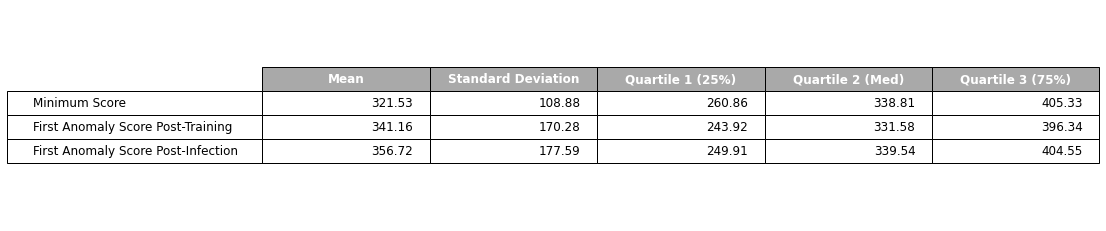

In [22]:
# Saving the Table
# Create a table visualization using matplotlib
fig, ax = plt.subplots(figsize=(6, 4))
ax.axis('off')
table1 = ax.table(cellText=df1.values, colLabels=df.columns1, rowLabels=df.index1, loc='center')
table1.auto_set_font_size(True)
table1.set_fontsize(14)
table1.scale(2.5, 2)  # Adjust the scaling factor as per your requirements

# Modify the column names as dark color boxes
for i, col_name in enumerate(df.columns1):
    cell = table1[0, i]
    cell.set_text_props(weight='bold', color='white')
    cell.set_facecolor('darkgray')
    
# Save the table as an image file
#plt.savefig('table_statistics_4days.png', bbox_inches='tight', facecolor='white')


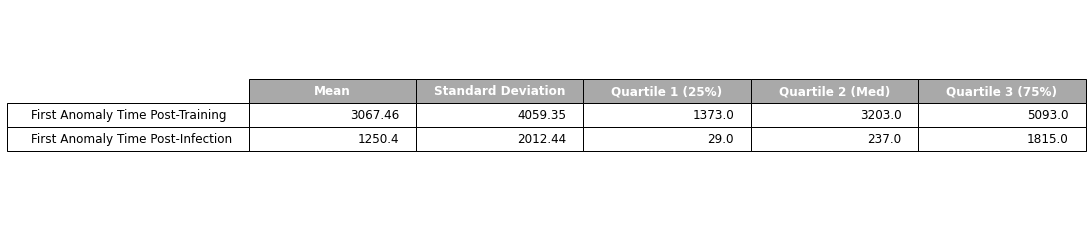

In [17]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.axis('off')
table2 = ax.table(cellText=df2.values, colLabels=df.columns2, rowLabels=df.index2, loc='center')
table2.auto_set_font_size(True)
table2.set_fontsize(14)
table2.scale(2.5, 2)  # Adjust the scaling factor as per your requirements

# Modify the column names as dark color boxes
for i, col_name in enumerate(df.columns2):
    cell = table2[0, i]
    cell.set_text_props(weight='bold', color='white')
    cell.set_facecolor('darkgray')

ValueError: 'rowLabels' must be of length 5

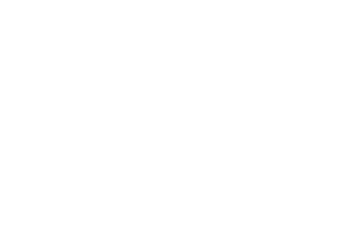

In [18]:
# Saving the Table
# Create a table visualization using matplotlib
fig, ax = plt.subplots(figsize=(6, 4))
ax.axis('off')
table3 = ax.table(cellText=df3.values, colLabels=df.columns3, rowLabels=df.index3, loc='center')
table3.auto_set_font_size(True)
table3.set_fontsize(14)
table3.scale(2.5, 2)  # Adjust the scaling factor as per your requirements

# Modify the column names as dark color boxes
for i, col_name in enumerate(df.columns3):
    cell = table3[0, i]
    cell.set_text_props(weight='bold', color='white')
    cell.set_facecolor('darkgray')

In [23]:
print("Mean: ", round(np.mean(ra)*100,2))
print("SD: ", round(np.std(ra)*100,2))
print("Q1: ", round(np.percentile(ra, 25)*100,2)) 
print("Q2: ", round(np.percentile(ra, 50)*100,2)) 
print("Q3: ", round(np.percentile(ra, 75)*100,2))

Mean:  19.9
SD:  29.79
Q1:  0.26
Q2:  2.19
Q3:  31.04


In [25]:
np.percentile(ra,50)

0.021868332825358123

In [21]:
ra.max()

0.8992599832449036

In [26]:
fai.min()

0

In [27]:
fai.max()

9711